# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU.

**Make sure you use the best practices you learned in class**.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
     plane        dog       bird       frog


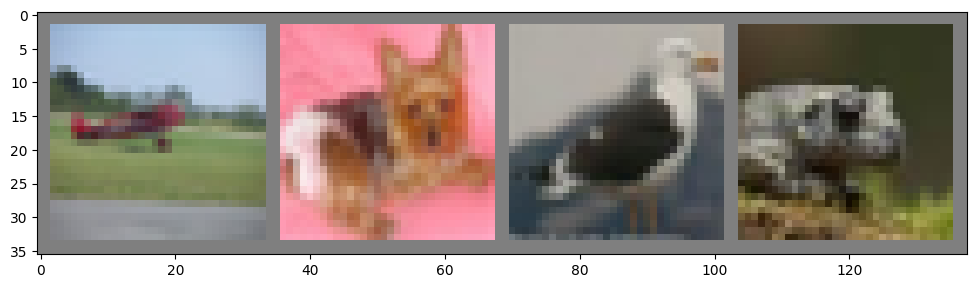

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value.

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class.
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs.
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.elu = nn.ELU()
        self.logSoftMax = nn.LogSoftmax(dim = 1)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################
        x = self.pool1(self.elu(self.bn1(self.conv1(x))))
        x = self.pool2(self.elu(self.bn2(self.conv2(x))))
        x = self.pool3(self.elu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)  # Adjusted based on the new architecture
        x = self.elu(self.fc1(x))
        x = self.fc2(x)
        x = self.logSoftMax(x)
        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net()
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   #
#############################################################################
# Loss function: CrossEntropy
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam. Default Parameters as in class (alpha=0.9, beta=0.999, epsilon=1e-8)
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Use StepLR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Using device: cuda
Epoch 1/10: Training Loss = 1.1665845533161212
Epoch 2/10: Training Loss = 0.799529744078741
Epoch 3/10: Training Loss = 0.6443083684920045
Epoch 4/10: Training Loss = 0.5258773491739313
Epoch 5/10: Training Loss = 0.4224009961842576
Epoch 6/10: Training Loss = 0.32515281380709177
Epoch 7/10: Training Loss = 0.23610276731726765
Epoch 8/10: Training Loss = 0.17004807214812398
Epoch 9/10: Training Loss = 0.133754644838288
Epoch 10/10: Training Loss = 0.10256783905989297


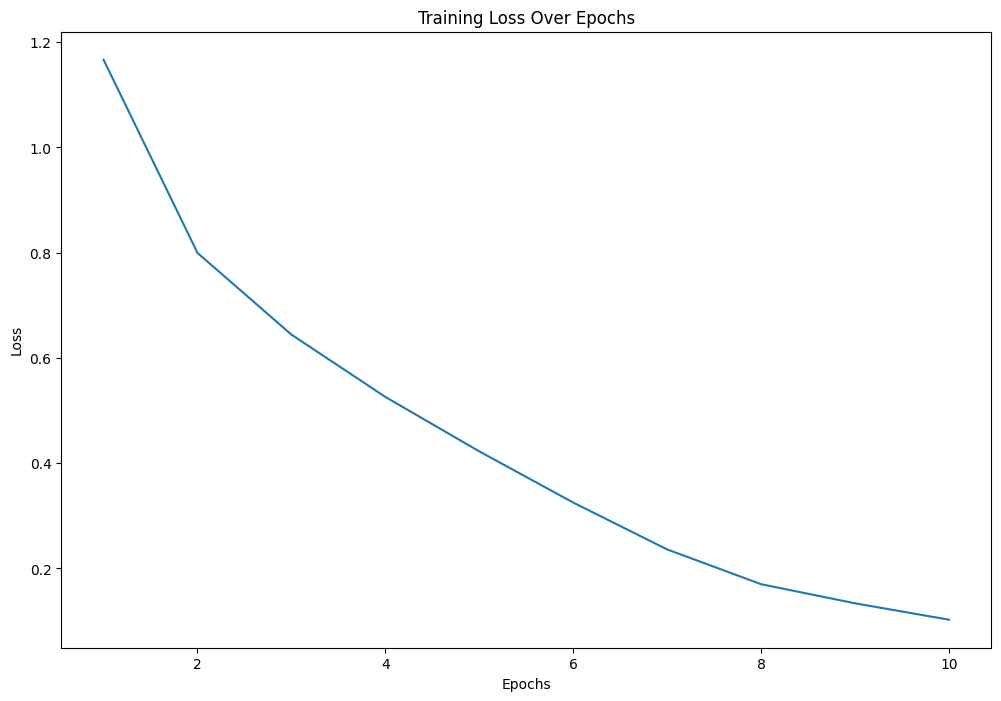

In [5]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        #
#############################################################################
num_epochs = 10

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
net =net.to(device)

loss_history = []

#Train the model
for epoch in range(num_epochs):
  epoch_loss = 0.0

  #Set the module in training mode
  net.train()

  # Iterate over batches in the training data
  for img, labels in trainloader:
    img, labels = img.to(device), labels.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = net(img)
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()


  # Calculate average loss for the epoch
  average_loss = epoch_loss / len(trainloader)
  loss_history.append(average_loss)
  print(f'Epoch {epoch+1}/{num_epochs}: Training Loss = {loss_history[-1]}')

#plot loss as function of epochs
plt.plot(range(1,num_epochs+1), loss_history)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)**

In [6]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        #
#############################################################################
# Set the model to evaluation mode
net.eval()

# Iterate over batches in the test data
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = net(inputs)

        # Get predicted labels
        _, predicted = torch.max(outputs, 1)

        # Update confusion matrix
        for i in range(len(labels)):
            confusion_matrix[labels[i]][predicted[i]] += 1

# Calculate accuracy using confusion matrix
model_accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix) * 100
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Model accuracy on 10000 test images: 76.43%


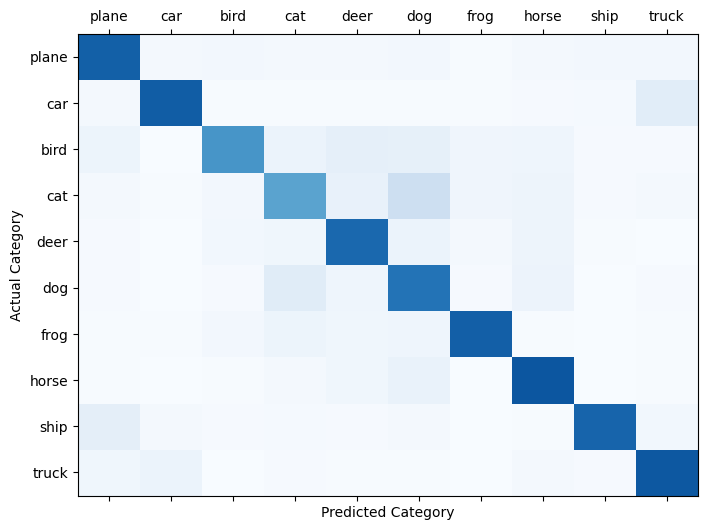

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question:**
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:** <br>
In my efforts to enhance a neural network model for CIFAR-10, I focused on architectural adjustments, regularization, and optimization to improve both performance and efficiency. Below are the key insights:

**Network Depth and Width:**

A complex, deep, and wide network initially seemed promising but led to overfitting and high computational costs. Simplifying the architecture by reducing layers and narrowing the width improved manageability and model generalization.

**Pooling Layers:**

Integrating additional pooling layers effectively reduced feature map dimensions, which decreased computational demands and accelerated training. This adjustment also improved feature extraction through spatial invariance.

**Dropout and Batch Normalization:**

Implementing dropout layers helped combat overfitting by randomly deactivating units during training. Batch normalization, applied alongside dropout, normalized layer inputs, stabilizing and speeding up the learning process. This technique facilitated the use of higher learning rates and reduced the need for precise initialization, indirectly enhancing the training dynamics.

**Optimization Techniques:**

Adaptive Learning Rates: Utilizing the Adam optimizer, known for its adaptive learning rate adjustments, significantly sped up model convergence. A learning rate scheduler further fine-tuned this process by dynamically modifying the learning rate, optimizing training results.

**Activation, Loss Functions, and Output Layer:**

**Activation Function:** The ELU function was selected for its efficiency and ability to prevent the vanishing gradient problem, outperforming other functions like sigmoid and tanh. Output Layer: I incorporated a softmax layer as the final step in the network to convert the logits into probabilities, providing a clear, normalized output for classification.

**Loss Function:** Cross Entropy Loss was chosen due to its effectiveness in multi-class classification scenarios. It excels at quantifying the difference between the predicted probability distribution and the actual distribution, making it ideal for this project.

**Output Layer:** A softmax layer was incorporated as the final step in the model. This layer is crucial for converting the logits into a probability distribution over the classes, ensuring the output is both normalized and interpretable for classification purposes.

**Conclusion**

My approach, centering on deliberate architectural and optimization modifications, led to significant advancements in accuracy and efficiency. Strategic use of dropout, batch normalization, adaptive learning rates, and the ELU activation function, combined with the softmax output layer and Cross Entropy Loss, were pivotal. These adjustments highlight the importance of a balanced network design and thoughtful optimization in achieving high performance in image classification tasks.

##**Question:**
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:**

This confusion matrix provides a comprehensive overview of a classification model's performance across different categories, highlighting not just the successes but also instances where the model confuses one class for another.

While accuracy offers a summary of overall performance, it can be misleading, especially in datasets with class imbalance, where it might disproportionately emphasize the majority class's influence.

The confusion matrix allows us to identify which classes are frequently confused by observing the 'bluer' cells—for example, it can show that cats are sometimes predicted as dogs, trucks as cars, birds as planes, and vice versa.

In conclusion, the confusion matrix is invaluable for diagnosing model performance beyond mere accuracy, revealing nuances in how different classes are handled and guiding targeted improvements in the model, particularly for classes that are easily confused or underrepresented.

# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs.

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images.

In [8]:
# ##dataloader.py
# from torch.utils.data import Dataset
# import torchvision.transforms.functional as F
# import os
# import sys
# import torch
# from PIL import Image
# import collections
# import numpy as np
# if sys.version_info[0] == 2:
#     import xml.etree.cElementTree as ET
# else:
#     import xml.etree.ElementTree as ET


# class VOCDetection(Dataset):
#     def __init__(self,
#                  root,
#                  image_set='trainval',
#                  transform=None,
#                  target_transform=None):
#         self.root = os.path.expanduser(root)
#         self.transform = transform
#         self.target_transform = target_transform
#         self.image_set = image_set
#         self.classes = ['cat', 'dog']

#         image_dir = os.path.join(self.root, 'images')
#         annotation_dir = os.path.join(self.root, 'annotations')

#         split_f = os.path.join(self.root, image_set.rstrip('\n') + '.txt')
#         with open(os.path.join(split_f), "r") as f:
#             file_names = [x.strip().split(' ')[0] for x in f.readlines()]
#         self.images = [os.path.join(image_dir, x + ".jpg") for x in file_names]
#         self.annotations = [os.path.join(annotation_dir, x + ".xml") for x in file_names]
#         assert (len(self.images) == len(self.annotations))

#     def __getitem__(self, index):
#         img = Image.open(self.images[index]).convert('RGB')
#         label, bbox = False, False
#         if(self.annotations):
#             target = self.parse_voc_xml(ET.parse(self.annotations[index]).getroot())
#             label = target['annotation']['object']['name']
#             if label == 'dog':
#                 label = 1
#             else:
#                 label = 0
#             x1, y1, x2, y2 = target['annotation']['object']['bndbox'].values()
#             x1 = int(x1)
#             y1 = int(y1)
#             x2 = int(x2)
#             y2 = int(y2)
#             bbox = np.array([x1, y1,x2, y2])
#         sample = {'image':img, 'label':label, 'bbox':bbox}
#         if self.transform is not None:
#             sample = self.transform(sample)
#         return sample

#     def __len__(self):
#         return len(self.images)

#     def parse_voc_xml(self, node):
#         voc_dict = {}
#         children = list(node)
#         if children:
#             def_dic = collections.defaultdict(list)
#             for dc in map(self.parse_voc_xml, children):
#                 for ind, v in dc.items():
#                     def_dic[ind].append(v)
#             voc_dict = {
#                 node.tag:
#                 {ind: v[0] if len(v) == 1 else v
#                  for ind, v in def_dic.items()}
#             }
#         if node.text:
#             text = node.text.strip()
#             if not children:
#                 voc_dict[node.tag] = text
#         return voc_dict


# class ToTensor(object):
#     def __call__(self, sample):
#         pic = sample['image']
#         sample['image'] = F.to_tensor(pic)
#         return sample

#     def __repr__(self):
#         return self.__class__.__name__ + '()'

# class Rescale(object):
#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         self.output_size = output_size

#     def __call__(self, sample):
#         image, label, bbox = sample['image'], sample['label'], sample['bbox']
#         h, w = image.size[:2]
#         if isinstance(self.output_size, int):
#             if h > w:
#                 new_h, new_w = self.output_size * h / w, self.output_size
#             else:
#                 new_h, new_w = self.output_size, self.output_size * w / h
#         else:
#             new_h, new_w = self.output_size
#         new_h, new_w = int(new_h), int(new_w)
#         img = F.resize(image, (new_h, new_w))
#         # h and w are swapped for landmarks because for images,
#         # x and y axes are axis 1 and 0 respectively
#         bbox = bbox * [new_h / h, new_w / w, new_h / h, new_w / w]
#         bbox = bbox / 224
#         bbox = torch.tensor(bbox, dtype=torch.float32)
#         return {'image':img, 'label':label, 'bbox':bbox}

# class Normalize(object):
#     def __init__(self, mean, std, inplace=False):
#         self.mean = mean
#         self.std = std
#         self.inplace = inplace

#     def __call__(self, sample):
#         img = sample['image']
#         sample['image'] = F.normalize(img, self.mean, self.std)
#         return sample

# def bb_intersection_over_union(boxA, boxB):
#     # determine the (x, y)-coordinates of the intersection rectangle
#     xA = max(boxA[0], boxB[0])
#     yA = max(boxA[1], boxB[1])
#     xB = min(boxA[2], boxB[2])
#     yB = min(boxA[3], boxB[3])

#     # compute the area of intersection rectangle
#     interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

#     # compute the area of both the prediction and ground-truth
#     # rectangles
#     boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
#     boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

#     # compute the intersection over union by taking the intersection
#     # area and dividing it by the sum of prediction + ground-truth
#     # areas - the interesection area
#     iou = interArea / float(boxAArea + boxBArea - interArea)

#     # return the intersection over union value
#     return iou


In [9]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

# from google.colab import drive
# drive.mount('/content/gdrive')
# sys.path.append('/content/gdrive/My Drive/Colab Notebooks/data')
# os.chdir('/content/gdrive/My Drive/Colab Notebooks')


To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [10]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [11]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)


{'train': 636, 'val': 158}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [12]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

<Figure size 1200x800 with 0 Axes>

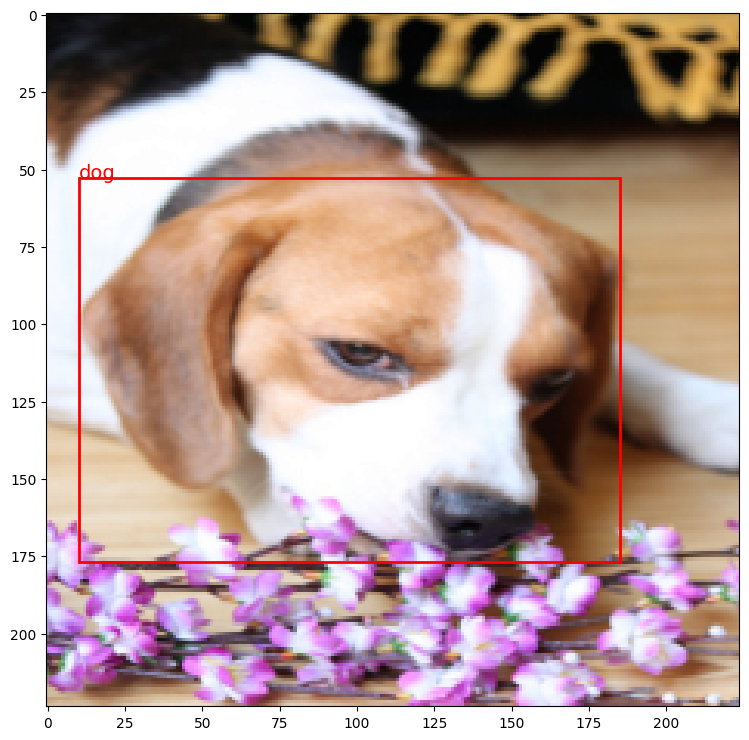

In [13]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only       #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # Clarrification - You required to build 2 models - one for classification  #
        # and one for detection.                                                    #
        # The classification model is of shape: resent_features -> FC/FCs -> scores.#
        # The detection model is of shape: resent_features -> FC/FCs -> bbox.       #
        # You may train/leave frozen the resent_features backbone, try              #
        # experimenting with it.                                                    #
        # This function has no return value.                                        #
        #############################################################################
        # Load pretrained ResNet-18 and remove the last fully connected layer
        self.features = nn.Sequential(*list(resnet18.children())[:-1])

        # Freeze ResNet-18 backbone
        for param in self.features.parameters():
            param.requires_grad = False

        # Define classification model
        self.classification_scores = nn.Sequential(nn.Flatten(),
            nn.Linear(in_features=512, out_features=128, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=num_classes)
        )

        # Define detection model
        self.detection_bbox = nn.Sequential(nn.Flatten(),
            nn.Linear(in_features=512, out_features=128, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=4, bias=True)
        )

        # Lists to store metrics for plotting
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.train_iou_history = []
        self.val_iou_history = []
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        x = self.features(images)
        classification_scores = self.classification_scores(x)
        bounding_box = self.detection_bbox(x)

        return classification_scores, bounding_box
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set.
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [15]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score

            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                inputs = sample['image'].to(device)
                labels = sample['label'].to(device)
                bboxes = sample['bbox'].to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                  out_labels, out_bboxes = model(inputs)
                  loss_cls = criterion_cls(out_labels, labels)
                  loss_bbox = criterion_bbox(out_bboxes, bboxes)

                  # Backward pass and optimization
                  if phase == 'train':
                    loss_cls.backward()
                    loss_bbox.backward()
                    optimizer.step()

                running_loss += loss_cls.item() * inputs.size(0) + loss_bbox.item() * inputs.size(0)
                _, preds_cls = torch.max(out_labels, 1)
                running_corrects += torch.sum(preds_cls == labels.data)

                for pred_box, true_box in zip(out_bboxes, bboxes):
                  iou += bb_intersection_over_union(pred_box, true_box)

                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]

            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            ####################################################################
            if phase == 'train':
                model.train_loss_history.append(epoch_loss)
                model.train_acc_history.append(epoch_acc.to("cpu"))
                model.train_iou_history.append(iou)
            else:
                model.val_loss_history.append(epoch_loss)
                model.val_acc_history.append(epoch_acc.to("cpu"))
                model.val_iou_history.append(iou)

            ####################################################################

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [16]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.SmoothL1Loss()

parameters = filter(lambda p: p.requires_grad, cnn.parameters())
optimizer = optim.Adam(parameters, lr=0.001)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [17]:
best_model = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.2867  |  Acc: 0.9198  |  IOU: 0.6057
val Loss: 0.0670  |  Acc: 0.9873  |  IOU: 0.6826
Epoch 2/10
----------
train Loss: 0.0710  |  Acc: 0.9811  |  IOU: 0.7082
val Loss: 0.0542  |  Acc: 0.9810  |  IOU: 0.7085
Epoch 3/10
----------
train Loss: 0.0615  |  Acc: 0.9843  |  IOU: 0.7217
val Loss: 0.0436  |  Acc: 0.9937  |  IOU: 0.7209
Epoch 4/10
----------
train Loss: 0.0398  |  Acc: 0.9937  |  IOU: 0.7421
val Loss: 0.0536  |  Acc: 0.9747  |  IOU: 0.7228
Epoch 5/10
----------
train Loss: 0.0444  |  Acc: 0.9874  |  IOU: 0.7500
val Loss: 0.0542  |  Acc: 0.9873  |  IOU: 0.7321
Epoch 6/10
----------
train Loss: 0.0310  |  Acc: 0.9937  |  IOU: 0.7587
val Loss: 0.0615  |  Acc: 0.9873  |  IOU: 0.7425
Epoch 7/10
----------
train Loss: 0.0436  |  Acc: 0.9858  |  IOU: 0.7661
val Loss: 0.0968  |  Acc: 0.9810  |  IOU: 0.7401
Epoch 8/10
----------
train Loss: 0.0670  |  Acc: 0.9748  |  IOU: 0.7689
val Loss: 0.0903  |  Acc: 0.9873  |  IOU: 0.7380
Epoch 9/10
----------
tr

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

<Figure size 1200x800 with 0 Axes>

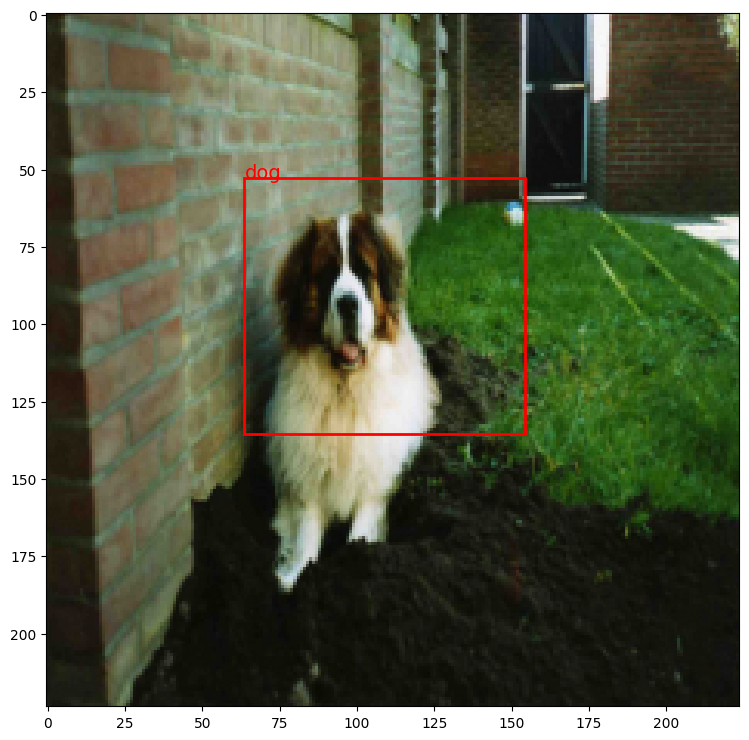

In [18]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

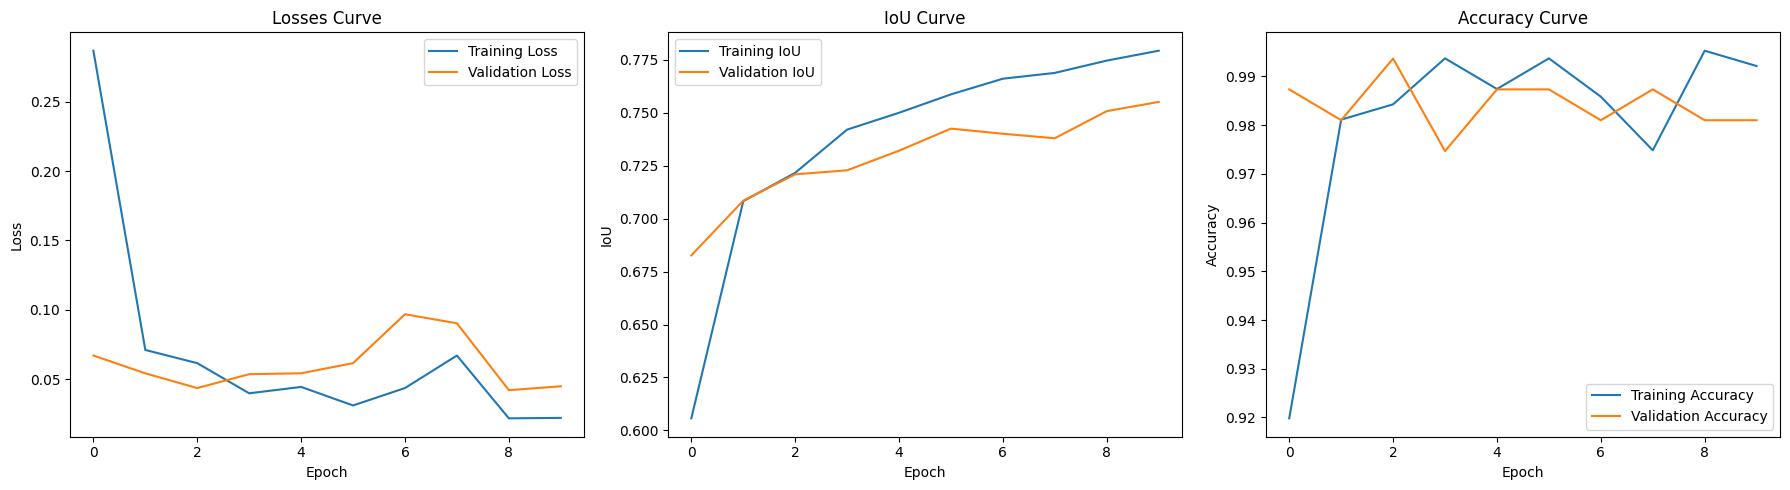

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))


# Plot loss history: plot loses as function of epochs
axs[0].plot(best_model.train_loss_history, label='Training Loss')
axs[0].plot(best_model.val_loss_history, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Losses Curve')
axs[0].legend()

# Plot IoU hostory as function of epochs
axs[1].plot(best_model.train_iou_history, label='Training IoU')
axs[1].plot(best_model.val_iou_history, label='Validation IoU')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('IoU')
axs[1].set_title('IoU Curve')
axs[1].legend()

# Plot accuracy as function of of epochs
axs[2].plot(best_model.train_acc_history, label='Training Accuracy')
axs[2].plot(best_model.val_acc_history, label='Validation Accuracy')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Accuracy Curve')
axs[2].legend()


plt.tight_layout()
plt.show()